**Purpose of notebook:** To leverage a VAE and latent space breakdown (z_rhythm and z_offset) to build a simple trading strategy for crude oil trading. Data leveraged is from Yahoo Finance between 2000 and 2024 as they are full years data.

**Phase 1**: We first collect the required data from Yahoo Finance, which includes closing price for crude on a given day

/tmp/ipython-input-2-2934776530.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


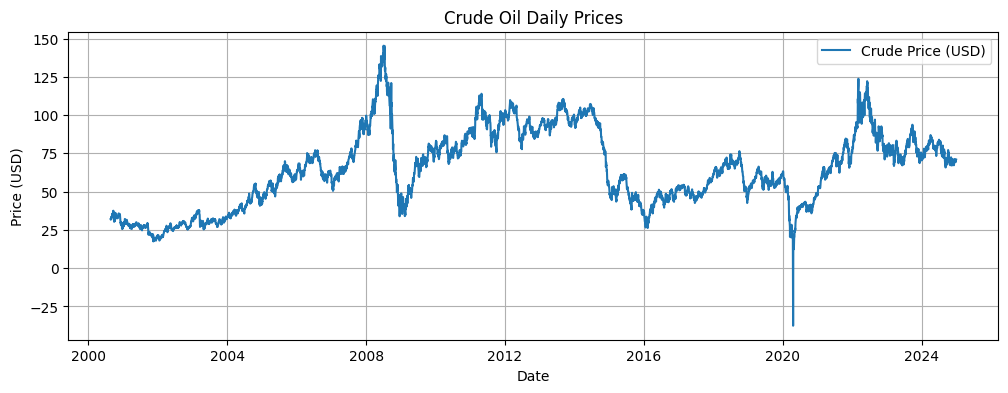

Price,Date,price
Ticker,,CL=F
0,2000-08-23,32.049999
1,2000-08-24,31.629999
2,2000-08-25,32.049999
3,2000-08-28,32.869999
4,2000-08-29,32.720001


In [2]:
# Install yfinance if not already installed
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Set ticker for CRUDE OIL Futures (COMEX)
ticker = "CL=F"
start_date = "1994-01-01"
end_date = "2024-12-31"

# Download data
data = yf.download(ticker, start=start_date, end=end_date)

# Keep only adjusted close price and clean
data = data[['Close']].rename(columns={'Close': 'price'})
data.dropna(inplace=True)
data.reset_index(inplace=True)

# Plot to visually inspect
plt.figure(figsize=(12, 4))
plt.plot(data['Date'], data['price'], label='Crude Price (USD)')
plt.title('Crude Oil Daily Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# Preview the first few rows
data.head()


**Observation**: We see that data above is continuous and spans  from Aug 2000 to Dec 2024. We now proceed to setting up the VAE neeeded

**Phase 2**: We set up the model for a dual latent VAE where one picks up the rhythm and the other offsets. Secret sauce is in the loss function that penalizes offsets and invokes them only when essential.

In [58]:


import torch
import torch.nn as nn
import torch.nn.functional as F

class DualLatentVAE(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64, latent_dim=8):
        super(DualLatentVAE, self).__init__()
        self.latent_dim = latent_dim

        # Shared encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(),                             #Multiple options exist here incl. ReLU, ELU, SELU, GELU; LeakyReLU is bad fit; ELU can in fact give better values.
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU()
        )

        # z_rhythm Gaussian head to detect rhythmic patterns in data
        self.mu_rhythm = nn.Linear(hidden_dim, latent_dim)
        self.logvar_rhythm = nn.Linear(hidden_dim, latent_dim)

        # z_offset Gaussian head to detext exceptions -- we expect this variable to work hard in crude pricing
        self.mu_offset = nn.Linear(hidden_dim, latent_dim)
        self.logvar_offset = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2 * latent_dim, hidden_dim), # twice latent dim given two latent variables
            nn.ELU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)

        # Rhythm latent
        mu_r = self.mu_rhythm(h)
        logvar_r = self.logvar_rhythm(h)
        z_r = self.reparameterize(mu_r, logvar_r)

        # Offset latent
        mu_o = self.mu_offset(h)
        logvar_o = self.logvar_offset(h)
        z_o = self.reparameterize(mu_o, logvar_o)

        # Concatenate latents and decode
        z = torch.cat([z_r, z_o], dim=1)
        recon = self.decoder(z)

        return recon, mu_r, logvar_r, mu_o, logvar_o


**Loss function:** As stated prior, the loss function is an important part of this setup. In addition to the standard Reconstruction losses and KL divergence , we set up an offset mean penalty that will ensure offset latents are invoked only when needed.

In [59]:
def dual_vae_loss(x, recon, mu_r, logvar_r, mu_o, logvar_o,
                  beta=1.0, offset_kl_weight=1.0, offset_norm_weight=1e-4):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon, x, reduction='mean')

    # KL divergences
    kl_rhythm = -0.5 * torch.sum(1 + logvar_r - mu_r.pow(2) - logvar_r.exp(), dim=1).mean()
    kl_offset = -0.5 * torch.sum(1 + logvar_o - mu_o.pow(2) - logvar_o.exp(), dim=1).mean()

    # Direct offset mean norm penalty
    offset_mean_penalty = torch.mean(torch.sum(mu_o**2, dim=1))  # L2 norm squared

    # Final weighted loss
    total_loss = (
        recon_loss
        + beta * kl_rhythm
        + offset_kl_weight * kl_offset
        + offset_norm_weight * offset_mean_penalty
    )
    return total_loss, recon_loss, kl_rhythm, kl_offset, offset_mean_penalty



**Data processing:** We deal with normalized prices for ease of modeling. The data is broken down into x-day rolling windows with a step size. The step size is determined by our expectations for patterns -- given the volatile nature of crude pricing, step size is smaller compared to a more seasonal commodity like wheat where we expect to see less movement.

Shape of rolling windows: (2018, 60, 1)


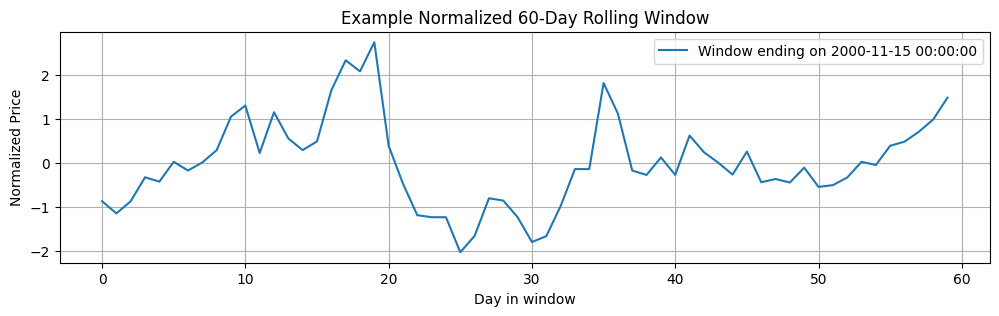

In [303]:
import numpy as np

# Set window size
window_size = 60
step = 3

prices = data['price'].values

# Create rolling windows
windows = []
dates = []

for i in range(0,len(prices) - window_size,step):
    window = prices[i:i + window_size]
    norm_window = (window - np.mean(window)) / (np.std(window) + 1e-8)  # z-score normalization
    windows.append(norm_window)
    dates.append(data['Date'].iloc[i + window_size - 1])  # use last date in window as label

windows = np.array(windows)
dates = np.array(dates)

print("Shape of rolling windows:", windows.shape)

# Optional: preview a few windows
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.plot(windows[0], label=f'Window ending on {dates[0]}')
plt.title('Example Normalized 60-Day Rolling Window')
plt.xlabel('Day in window')
plt.ylabel('Normalized Price')
plt.grid(True)
plt.legend()
plt.show()


**Additional processing**: Code block below ensures that the data is sent in the appropriate tensor form as needed by the VAE model

In [304]:
import torch
from torch.utils.data import Dataset, DataLoader

# Reshape for PyTorch (batch, features)
windows_tensor = torch.tensor(windows, dtype=torch.float32)  # shape: (N, 30 or as defined)
# If needed, unsqueeze last dim for 1D input
windows_tensor = windows_tensor.view(windows_tensor.shape[0], -1)  # (N, 30 or as defined)

# Custom dataset
class CrudeRollingDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):

        return self.data[idx]

# Define split index
split_idx = int(0.7 * windows_tensor.shape[0])  # 70% train, 30% test

# Split into training and testing sets
train_tensor = windows_tensor[:split_idx]
test_tensor = windows_tensor[split_idx:]

train_dates = dates[:split_idx]
test_dates = dates[split_idx:]

split_price_idx = step * split_idx

train_prices = prices[:split_price_idx]
test_prices = prices[split_price_idx:]

# Wrap into datasets
train_dataset = CrudeRollingDataset(train_tensor)
test_dataset = CrudeRollingDataset(test_tensor)

# Create separate dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Sanity check
for batch in train_loader:
    print("Batch shape:", batch.shape)
    break


Batch shape: torch.Size([64, 60])


**Phase 3 (Training)**: Following code blocks set up the training phase of the VAE.

In [305]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_dim = 8
hidden_dim = 64
input_dim = 60 ##Has to match the window size used
lr = 1e-3
num_epochs = 50
beta = 1.0               # weight for rhythm KL
offset_penalty = 2.0     # stronger penalty for z_offset KL

# Model
modelVAE = DualLatentVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(modelVAE.parameters(), lr=lr)


**Note**: In the training below, we add some Gaussian noise so that the model is incentivized to identify rhythm and offset patterns.

In [306]:
# Updated hyperparameters
num_epochs = 50
kl_warmup_epochs = 40
noise_std = 0.05  # input Gaussian noise

# Norm penalties (static)
offset_kl_weight = 0.2
offset_norm_weight = 1e-4

# Reset losses
losses = {'total': [], 'recon': [], 'kl_rhythm': [], 'kl_offset': []}

for epoch in range(num_epochs):
    modelVAE.train()
    epoch_total, epoch_recon, epoch_kl_r, epoch_kl_o = 0, 0, 0, 0

    # Linearly increase KL weight
    beta = min(1.0, epoch / kl_warmup_epochs)

    for batch in train_loader:
        batch = batch.to(device)

        # Add Gaussian noise to inputs
        noisy_batch = batch + torch.randn_like(batch) * noise_std

        # Forward pass
        recon, mu_r, logvar_r, mu_o, logvar_o = modelVAE(noisy_batch)

        # Compute loss using current beta and static norm weights
        loss, recon_loss, kl_r, kl_o, offset_norm = dual_vae_loss(
        batch, recon, mu_r, logvar_r, mu_o, logvar_o,
        beta=beta,
        offset_kl_weight=offset_kl_weight,
        offset_norm_weight=offset_norm_weight
        )


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        epoch_total += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl_r += kl_r.item()
        epoch_kl_o += kl_o.item()

    n_batches = len(train_loader)
    print(f"Epoch {epoch+1:02d} | Total: {epoch_total/n_batches:.4f} | Recon: {epoch_recon/n_batches:.4f} | KL_r: {epoch_kl_r/n_batches:.4f} | KL_o: {epoch_kl_o/n_batches:.4f} | β={beta:.2f}")

    losses['total'].append(epoch_total / n_batches)
    losses['recon'].append(epoch_recon / n_batches)
    losses['kl_rhythm'].append(epoch_kl_r / n_batches)
    losses['kl_offset'].append(epoch_kl_o / n_batches)



Epoch 01 | Total: 1.0142 | Recon: 1.0013 | KL_r: 0.6362 | KL_o: 0.0647 | β=0.00
Epoch 02 | Total: 0.7575 | Recon: 0.6437 | KL_r: 4.2601 | KL_o: 0.0365 | β=0.03
Epoch 03 | Total: 0.7089 | Recon: 0.5733 | KL_r: 2.6123 | KL_o: 0.0252 | β=0.05
Epoch 04 | Total: 0.7215 | Recon: 0.5646 | KL_r: 2.0370 | KL_o: 0.0203 | β=0.07
Epoch 05 | Total: 0.7509 | Recon: 0.5821 | KL_r: 1.6526 | KL_o: 0.0179 | β=0.10
Epoch 06 | Total: 0.7805 | Recon: 0.5886 | KL_r: 1.5108 | KL_o: 0.0157 | β=0.12
Epoch 07 | Total: 0.8147 | Recon: 0.6187 | KL_r: 1.2854 | KL_o: 0.0159 | β=0.15
Epoch 08 | Total: 0.8153 | Recon: 0.6210 | KL_r: 1.0910 | KL_o: 0.0164 | β=0.17
Epoch 09 | Total: 0.8470 | Recon: 0.6626 | KL_r: 0.9055 | KL_o: 0.0164 | β=0.20
Epoch 10 | Total: 0.8677 | Recon: 0.6722 | KL_r: 0.8526 | KL_o: 0.0183 | β=0.23
Epoch 11 | Total: 0.8661 | Recon: 0.6744 | KL_r: 0.7501 | KL_o: 0.0208 | β=0.25
Epoch 12 | Total: 0.8747 | Recon: 0.6959 | KL_r: 0.6347 | KL_o: 0.0212 | β=0.28
Epoch 13 | Total: 0.8827 | Recon: 0.7060

In [307]:
!pip install matplotlib scikit-learn --quiet


**Phase 4 (Visualizations)**: We first begin with visualizations of the offset space

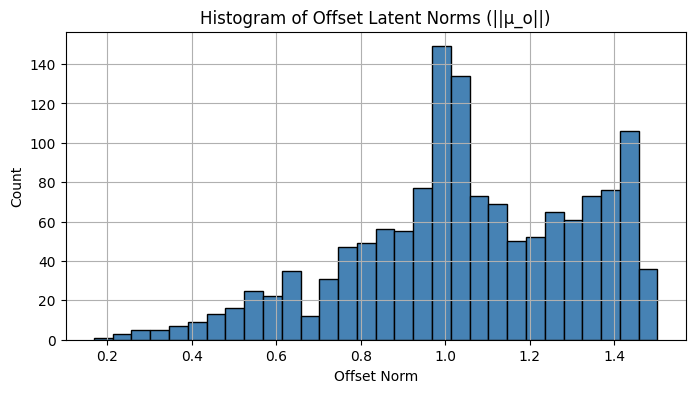

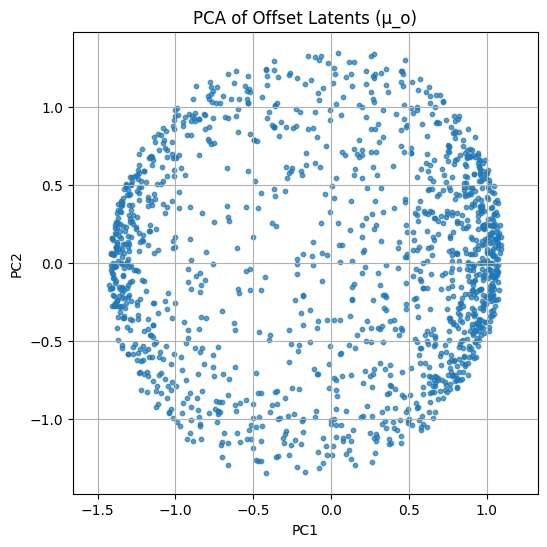

In [308]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Collect all offset means (mu_o)
all_mu_o = []

modelVAE.eval()
with torch.no_grad():
    for batch in train_loader:  # or use your dataset if smaller
        batch = batch.to(device).float()
        _, _, _, mu_o_batch, _ = modelVAE(batch)
        all_mu_o.append(mu_o_batch.cpu())

# Stack all offset latent vectors
train_mu_o_matrix = torch.cat(all_mu_o, dim=0).numpy()
train_mu_o_all = np.concatenate(all_mu_o, axis=0)

# ---- Histogram of offset norms ---- #
offset_norms = (train_mu_o_matrix ** 2).sum(axis=1) ** 0.5

plt.figure(figsize=(8, 4))
plt.hist(offset_norms, bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Offset Latent Norms (||μ_o||)")
plt.xlabel("Offset Norm")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# ---- PCA projection ---- #
pca = PCA(n_components=2)
mu_o_pca = pca.fit_transform(train_mu_o_matrix)

plt.figure(figsize=(6, 6))
plt.scatter(mu_o_pca[:, 0], mu_o_pca[:, 1], alpha=0.7, s=10)
plt.title("PCA of Offset Latents (μ_o)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.axis('equal')
plt.show()


**Observation:**As expected the offsets are skewed towards higher values, indicating that they are getting used but not easily, which aligns with the KL term and the additional penalty levied on offset. Plot below will also show how the offset separates into concentric regions of increasing values

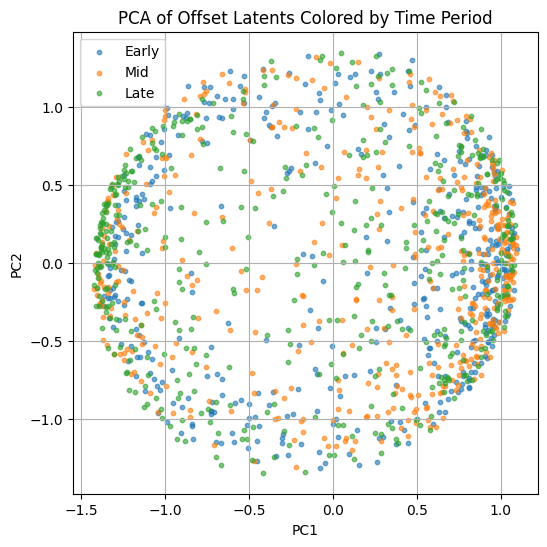

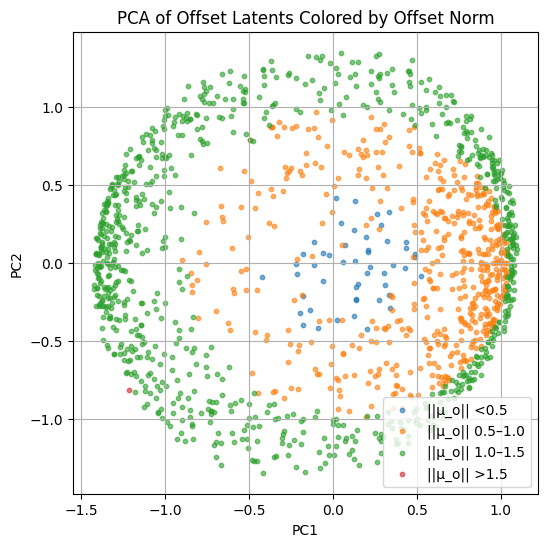

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# --- Setup (replace these with your real data if needed) ---
# mu_o_all: shape (N, latent_dim)
# offset_norms: shape (N,)
# dates: list or array of datetime objects, length N
# For example:
# dates = np.array(pd.date_range(start="2010-01-01", periods=len(offset_norms)))

# Run PCA
pca = PCA(n_components=2)
mu_o_pca = pca.fit_transform(train_mu_o_matrix)

# Create DataFrame for plotting
df = pd.DataFrame({
    'PC1': mu_o_pca[:, 0],
    'PC2': mu_o_pca[:, 1],
    'OffsetNorm': offset_norms,
    'Date': train_dates
})

# --- 1. Color by TIME PERIOD ---
# Define time bins: early, mid, late
cutoffs = np.percentile(df['Date'].astype(np.int64), [33, 66])
df['TimePeriod'] = pd.cut(df['Date'].astype(np.int64),
                          bins=[df['Date'].astype(np.int64).min(), *cutoffs, df['Date'].astype(np.int64).max()],
                          labels=['Early', 'Mid', 'Late'])

# Plot by time period
plt.figure(figsize=(6,6))
for period in ['Early', 'Mid', 'Late']:
    subset = df[df['TimePeriod'] == period]
    plt.scatter(subset['PC1'], subset['PC2'], label=period, alpha=0.6, s=10)
plt.title("PCA of Offset Latents Colored by Time Period")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Color by OFFSET NORM BIN ---
# Define norm bins (you can change these)
norm_bins = [0, 0.5, 1.0, 1.5, np.inf]
df['NormBin'] = pd.cut(df['OffsetNorm'], bins=norm_bins, labels=["<0.5", "0.5–1.0", "1.0–1.5", ">1.5"])

# Plot by norm bin
plt.figure(figsize=(6,6))
for label in df['NormBin'].cat.categories:
    subset = df[df['NormBin'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f"||μ_o|| {label}", alpha=0.6, s=10)
plt.title("PCA of Offset Latents Colored by Offset Norm")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


We repeat the same exercises for rhythm and see that the patterns aren't really strongly there, which is expected given the nature of crude prices and the window size we are using (about a month, perhaps more rhythm exists on longer cycles, which can be investigated in future work)

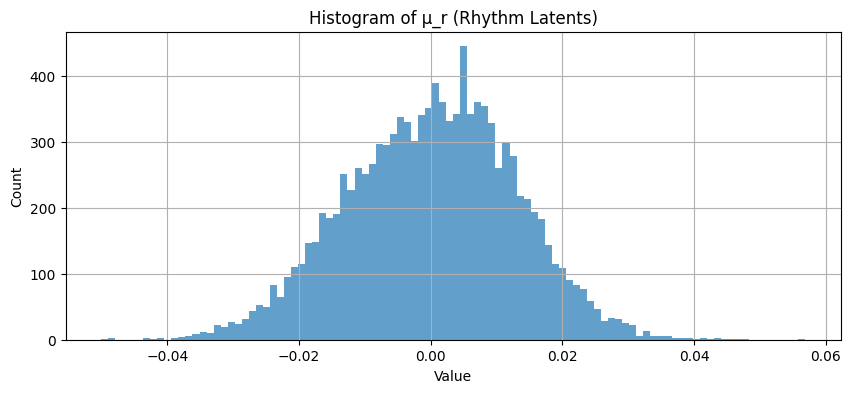

In [310]:
all_mu_r = []

modelVAE.eval()
with torch.no_grad():
    for batch in train_loader:  # or use your dataset if smaller
        batch = batch.to(device).float()
        _, mu_r_batch, _, _, _ = modelVAE(batch)
        all_mu_r.append(mu_r_batch.cpu())

# Assuming you already have mu_r from encoding all batches
train_mu_r_all = np.concatenate(all_mu_r, axis=0)  # (N, latent_dim)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(train_mu_r_all.flatten(), bins=100, alpha=0.7)
plt.title("Histogram of μ_r (Rhythm Latents)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.grid(True)
plt.show()


/tmp/ipython-input-311-2793172191.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", 12)


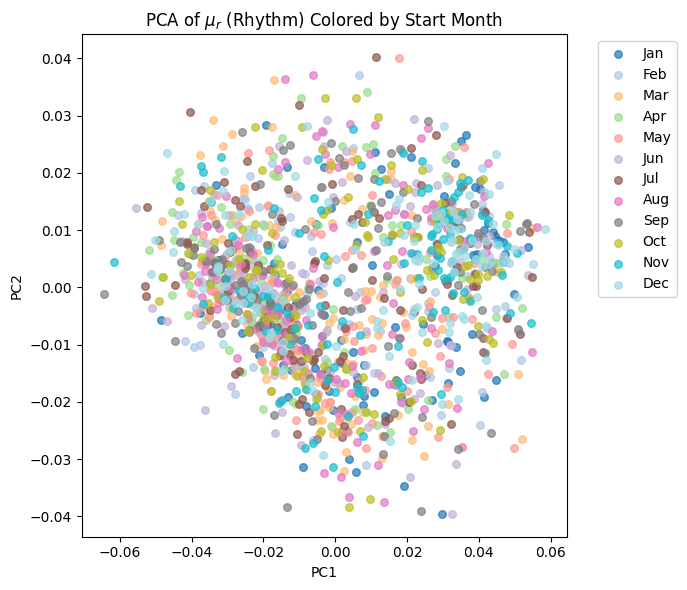

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# Assumes you have: mu_rhythm (193, latent_dim), dates (193,)

# Convert to PCA
pca = PCA(n_components=2)
z_rhythm_pca = pca.fit_transform(train_mu_r_all)

# Extract start months
start_months = pd.to_datetime(train_dates).month
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = plt.cm.get_cmap("tab20", 12)

# Plot
plt.figure(figsize=(7, 6))
for month in range(1, 13):
    idx = start_months == month
    plt.scatter(z_rhythm_pca[idx, 0], z_rhythm_pca[idx, 1],
                label=month_labels[month - 1], s=30, alpha=0.7, color=colors(month - 1))

plt.title("PCA of $\\mu_r$ (Rhythm) Colored by Start Month")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Phase 5 (Modeling):** We now begin preparing test data and training data for modeling purposes. We want to set up the returns as seen over a 20 day period post each window

In [411]:
import numpy as np

# Example values (replace with your actual ones)
forecast_horizon = 20
window_size = 60
step = 3

log_train_prices = np.log(train_prices + 1e-8)

train_future_returns = []
train_valid_indices = []

for i in range(0, len(log_train_prices) - window_size - forecast_horizon, step):
    end_idx = i + window_size
    future_idx = end_idx + forecast_horizon

    r = log_train_prices[future_idx] - log_train_prices[end_idx - 1]  # log-return
    train_future_returns.append(r)
    train_valid_indices.append(i)

train_future_return = np.array(train_future_returns)
print(f"Train Future returns shape: {train_future_return.shape}")


Train Future returns shape: (1386, 1)


Following block ensures consistent dimensionality of all test data.

In [412]:
min_len = min(len(train_future_return), len(train_mu_r_all), len(train_mu_o_all))
train_future_return = train_future_return[:min_len]
train_mu_r_all = train_mu_r_all[:min_len]
train_mu_o_all = train_mu_o_all[:min_len]

Same process is now repeated for training data

In [413]:
#Test data also needs same work

import numpy as np

test_prices = np.clip(test_prices, a_min=1e-4, a_max=None)
log_test_prices = np.log(test_prices)

test_future_returns = []
test_valid_indices = []

for i in range(0, len(log_test_prices) - window_size - forecast_horizon, step):
    end_idx = i + window_size
    future_idx = end_idx + forecast_horizon

    r = log_test_prices[future_idx] - log_test_prices[end_idx - 1]  # log-return
    test_future_returns.append(r)
    test_valid_indices.append(i)

test_future_return = np.array(test_future_returns)
print(f"Test Future returns shape: {test_future_return.shape}")


Test Future returns shape: (600, 1)


We next obtain all the means for offest and rhythm for training and test data

In [414]:
test_all_mu_o = []

modelVAE.eval()
with torch.no_grad():
    for batch in test_loader:  # or use your dataset if smaller
        batch = batch.to(device).float()
        _, _, _, mu_o_batch, _ = modelVAE(batch)
        test_all_mu_o.append(mu_o_batch.cpu())

# Stack all offset latent vectors
test_mu_o_matrix = torch.cat(test_all_mu_o, dim=0).numpy()
test_mu_o_all = np.concatenate(test_all_mu_o, axis=0)

In [415]:
test_all_mu_r = []

modelVAE.eval()
with torch.no_grad():
    for batch in test_loader:  # or use your dataset if smaller
        batch = batch.to(device).float()
        _, mu_r_batch, _, _, _ = modelVAE(batch)
        test_all_mu_r.append(mu_r_batch.cpu())

# Stack all offset latent vectors
test_mu_r_matrix = torch.cat(test_all_mu_r, dim=0).numpy()
test_mu_r_all = np.concatenate(test_all_mu_r, axis=0)

In [416]:
min_len = min(len(test_future_return), len(test_mu_r_all), len(test_mu_o_all))
test_future_return = test_future_return[:min_len]
test_mu_r_all = test_mu_r_all[:min_len]
test_mu_o_all = test_mu_o_all[:min_len]

**Phase 6 (Regressions)**: We now run regressions to see whether target variable (a binary variable that takes 0 or 1 value based on whether future returns are positive or negative) can be predicted via mu_rhythm and mu_offset

In [417]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create binary target: 1 if return > 0
train_y_binary = (train_future_return > 0).astype(int)

# Concatenate latent features
train_X = np.hstack([train_mu_r_all, train_mu_o_all])

# Sanity check
print("Feature shape:", train_X.shape)
print("Target shape:", train_y_binary.shape)

# Fit logistic regression with cross-validation
clf = LogisticRegressionCV(cv=5, max_iter=1000, scoring='roc_auc', penalty='l2', solver='liblinear')
clf.fit(train_X, train_y_binary.ravel())


Feature shape: (1376, 16)
Target shape: (1376, 1)


LogisticRegressionCV(cv=5, max_iter=1000, scoring='roc_auc', solver='liblinear')

In [418]:
test_X = np.hstack([test_mu_r_all, test_mu_o_all])
test_y_binary = (test_future_return > 0).astype(int)

y_pred_test = clf.predict(test_X)
y_prob_test = clf.predict_proba(test_X)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

acc = accuracy_score(test_y_binary, y_pred_test)
auc = roc_auc_score(test_y_binary, y_prob_test)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC: {auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(test_y_binary, y_pred_test))

Test Accuracy: 0.5450
Test AUC: 0.5309
Confusion Matrix:
[[ 90 173]
 [100 237]]


**Result**: We see that the AUC is modest but as we will see below it can still give meaningful trading strategies

Alternatively we can also run a XGBoost to see how things work:

In [419]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

clfxgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

clfxgb.fit(train_X, train_y_binary.ravel())
y_val_prob = clfxgb.predict_proba(test_X)[:, 1]
auc = roc_auc_score(test_y_binary, y_val_prob)

print(f"🔍 XGBoost Validation AUC: {auc:.4f}")


🔍 XGBoost Validation AUC: 0.5792


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:04:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [420]:
np.bincount(np.array(train_y_binary).flatten())



array([625, 751])

In [370]:
assert not np.isnan(y_pred_test).any()

In [371]:
assert not np.isnan(test_future_return).any()
assert not np.isnan(y_prob_test).any()

**Phase 7**: We set up a simple POC backtesting strategy where we define extry and exit thresholds, stop loss values, and see whether the strategy can be useful.

In [426]:
import numpy as np
import pandas as pd

# Strategy parameters
entry_threshold = 0.65
exit_threshold = 0.5

# Step 1: Generate positions based on probability bands
raw_positions = np.where(y_val_prob > entry_threshold, 1,
                 np.where(y_val_prob < exit_threshold, 0, np.nan))  # NaN = Hold last

# Step 2: Forward fill to simulate position holding
positions = pd.Series(raw_positions).ffill().fillna(0).values  # Start flat

# --------------------------
# Trade Count and Durations
# --------------------------
entry_indices = np.where((positions[1:] == 1) & (positions[:-1] == 0))[0] + 1
exit_indices = np.where((positions[1:] == 0) & (positions[:-1] == 1))[0] + 1

# Handle open trade at the start
if positions[0] == 1:
    entry_indices = np.insert(entry_indices, 0, 0)

# Handle open trade at the end
if positions[-1] == 1:
    exit_indices = np.append(exit_indices, len(positions))

# Pair each entry with the next available exit
trade_durations = []
exit_cursor = 0

for entry in entry_indices:
    # Find the first exit after this entry
    while exit_cursor < len(exit_indices) and exit_indices[exit_cursor] <= entry:
        exit_cursor += 1
    if exit_cursor < len(exit_indices):
        exit = exit_indices[exit_cursor]
        trade_durations.append(exit - entry)
        exit_cursor += 1  # move on to next exit

num_trades = len(trade_durations)
avg_duration = np.mean(trade_durations) if num_trades > 0 else 0

avg_duration = np.mean(trade_durations) if len(trade_durations) > 0 else 0
print(f"Average Trade Duration: {avg_duration} days")
print(f"Total Trades: {num_trades}")

# Step 3: Compute strategy returns
strategy_returns = positions * test_future_return.flatten()
strategy_returns = np.clip(strategy_returns, -0.02, 0.10)  # Example: cap loss at -5%, gain at 10%
# Step 4: Compute cumulative return
cumulative_returns = np.cumprod(1 + strategy_returns)

# -------------------------------
# Performance Metrics (Optional)
# -------------------------------

def calculate_cagr(returns, periods_per_year=252):
    cumulative = np.cumprod(1 + returns)[-1]
    n_periods = len(returns)
    return cumulative**(periods_per_year / n_periods) - 1

def calculate_sharpe(returns, risk_free_rate=0.0, periods_per_year=252):
    excess = returns - (risk_free_rate / periods_per_year)
    return np.mean(excess) / np.std(excess) * np.sqrt(periods_per_year)

def calculate_sortino(returns, risk_free_rate=0.0, periods_per_year=252):
    downside = returns[returns < 0]
    if len(downside) == 0:
        return np.nan
    downside_std = np.std(downside)
    excess = returns - (risk_free_rate / periods_per_year)
    return np.mean(excess) / downside_std * np.sqrt(periods_per_year)

def calculate_max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Step 5: Print metrics
cagr = calculate_cagr(strategy_returns)
sharpe = calculate_sharpe(strategy_returns)
sortino = calculate_sortino(strategy_returns)
max_dd = calculate_max_drawdown(cumulative_returns)

print(f"📈 CAGR: {cagr * 100:.2f}%")
print(f"⚖️ Sharpe Ratio: {sharpe:.2f}")
print(f"📉 Max Drawdown: {max_dd * 100:.2f}%")
print(f"📊 Sortino Ratio: {sortino:.2f}")


Average Trade Duration: 5.846153846153846 days
Total Trades: 39
📈 CAGR: 1523.89%
⚖️ Sharpe Ratio: 5.73
📉 Max Drawdown: -23.21%
📊 Sortino Ratio: 37.92


In [423]:
#Statistics for finetuning

import numpy as np

# Example array
arr = np.array(y_val_prob)  # your data here

print("Count:", len(arr))
print("Mean:", np.mean(arr))
print("Std Dev:", np.std(arr))
print("Min:", np.min(arr))
print("Max:", np.max(arr))
print("25th percentile:", np.percentile(arr, 25))
print("Median:", np.median(arr))
print("75th percentile:", np.percentile(arr, 75))
print("Skew:", (np.mean((arr - np.mean(arr))**3)) / (np.std(arr)**3))
print("Kurtosis:", (np.mean((arr - np.mean(arr))**4)) / (np.std(arr)**4))


Count: 600
Mean: 0.54422575
Std Dev: 0.12260964
Min: 0.28219414
Max: 0.9213465
25th percentile: 0.43802172
Median: 0.54059696
75th percentile: 0.631737
Skew: 0.43904486
Kurtosis: 2.7212281
